In [51]:
!pip3 install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pareto

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [53]:
from google.colab import drive
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [30]:
ddl = xes_importer.apply('/drive/MyDrive/BPI-2020/DomesticDeclarations.xes.gz')
idl = xes_importer.apply('/drive/MyDrive/BPI-2020/InternationalDeclarations.xes.gz')
pl = xes_importer.apply('/drive/MyDrive/BPI-2020/PermitLog.xes.gz')
ptcl = xes_importer.apply('/drive/MyDrive/BPI-2020/PrepaidTravelCost.xes.gz')
rfpl = xes_importer.apply('/drive/MyDrive/BPI-2020/RequestForPayment.xes.gz')

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/2099 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

In [31]:
idl[0][1]

{'id': 'rv_travel permit 76455_7', 'org:resource': 'STAFF MEMBER', 'concept:name': 'End trip', 'time:timestamp': datetime.datetime(2016, 10, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'org:role': 'EMPLOYEE'}

In [32]:
pm4py.get_start_activities(idl)

{'Declaration SAVED by EMPLOYEE': 8,
 'Declaration SUBMITTED by EMPLOYEE': 407,
 'Permit SUBMITTED by EMPLOYEE': 5294,
 'Start trip': 740}

In [33]:
activities = pm4py.get_event_attribute_values(idl,"concept:name")
print(len(activities))
activities_low_freq = dict(filter(lambda x: x[1] < 300, activities.items()))
activities_high_freq = dict(filter(lambda x: x[1] > 300, activities.items()))
activities_high_freq
activities_low_freq # activities with low frequency
print("low freqs: ",len(activities_low_freq))
table_view  = pd.DataFrame.from_dict(activities_low_freq.items())
table_view


34
low freqs:  15


,0,1
0,Declaration REJECTED by PRE_APPROVER,84
1,Declaration SAVED by EMPLOYEE,75
2,Declaration REJECTED by MISSING,103
3,Permit REJECTED by MISSING,43
4,Declaration REJECTED by SUPERVISOR,126
5,Declaration APPROVED by SUPERVISOR,256
6,Declaration FINAL_APPROVED by DIRECTOR,252
7,Permit REJECTED by PRE_APPROVER,25
8,Permit REJECTED by EMPLOYEE,231
9,Declaration REJECTED by DIRECTOR,4


In [34]:
pm4py.get_end_activities(idl)

{'Declaration FINAL_APPROVED by SUPERVISOR': 1,
 'Declaration REJECTED by EMPLOYEE': 130,
 'Declaration REJECTED by MISSING': 11,
 'Declaration REJECTED by SUPERVISOR': 1,
 'Declaration SAVED by EMPLOYEE': 54,
 'End trip': 593,
 'Payment Handled': 5646,
 'Permit REJECTED by MISSING': 8,
 'Request Payment': 3,
 'Send Reminder': 2}

## Variant Analysis

In [35]:
from pm4py.statistics.traces.generic.log import case_statistics
idl_variants_count = case_statistics.get_variant_statistics(idl)

len(idl_variants_count)

753

In [36]:
idl_variants = pm4py.get_variants(idl)
idl_df = pd.DataFrame.from_dict(idl_variants_count)
# idl_df = pm4py.convert_to_dataframe(idl_variants_count)
idl_df

/usr/local/lib/python3.7/dist-packages/pm4py/stats.py:219: UserWarning: pm4py.get_variants is deprecated. Please use pm4py.get_variants_as_tuples instead.
  warnings.warn('pm4py.get_variants is deprecated. Please use pm4py.get_variants_as_tuples instead.')


,variant,count
0,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",1369
1,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",624
2,"Permit SUBMITTED by EMPLOYEE,Permit FINAL_APPR...",361
3,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",311
4,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",254
...,...,...
748,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",1
749,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",1
750,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",1
751,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",1


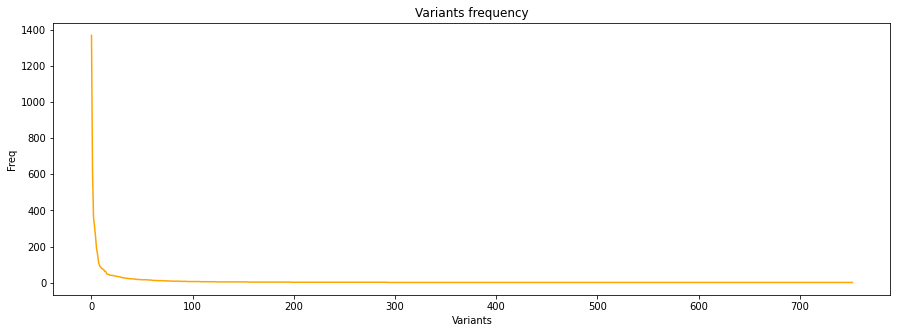

In [37]:
variant = idl_df.index
frequency = idl_df['count']
freq_log = [math.log(i,2) for i in frequency ]
fig = plt.figure(figsize = (15,5))
plt.plot(variant,frequency, color = 'orange')
plt.xlabel('Variants')
plt.ylabel('Freq')
plt.title('Variants frequency')
plt.show()

In [38]:
idl_df = log_converter.apply(idl, variant=log_converter.Variants.TO_DATA_FRAME)
p = idl_df.groupby('case:concept:name').agg(
Activity = ('concept:name', 'count'),\
Activity_list = ('concept:name', lambda x: ','.join(x) ),\
Resource = ('org:resource', 'nunique'),\
Duration = ('time:timestamp', lambda x: x.max()- x.min()),\
)
p


,Activity,Activity_list,Resource,Duration
case:concept:name,,,,
declaration 1002,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,39 days 05:35:41
declaration 10024,12,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,62 days 02:39:44
declaration 10026,12,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,62 days 02:39:44
declaration 10046,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,86 days 02:38:23
declaration 10069,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,8 days 01:03:09
...,...,...,...,...
declaration 9934,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,52 days 04:56:43
declaration 9945,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,49 days 02:16:33
declaration 9955,12,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,93 days 06:46:03


In [39]:
from datetime import timedelta
p_sorted = dataframe_utils.convert_timestamp_columns_in_df(p)
p_sorted = p.sort_values('Duration',ascending=False)
p_sorted['Duration'] < timedelta(days=100)
p_sorted

,Activity,Activity_list,Resource,Duration
case:concept:name,,,,
declaration 61184,16,"Start trip,Permit SUBMITTED by EMPLOYEE,Permit...",2,742 days 00:00:00
declaration 7483,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,463 days 01:15:43
declaration 143637,6,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",2,458 days 14:12:24
declaration 143644,12,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",2,458 days 11:42:47
declaration 143578,6,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",2,458 days 08:39:42
...,...,...,...,...
declaration 30793,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,7 days 07:41:11
declaration 146876,7,"Declaration SUBMITTED by EMPLOYEE,Declaration ...",2,7 days 05:45:56
declaration 34709,10,"Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...",2,7 days 01:21:22


In [59]:
import datetime
deltas = [row['Duration'] for index, row in p_sorted.iterrows()]
deltas = deltas[1:] # removing the first and importat noise
deltas_df = pd.DataFrame(deltas)
deltas_df.mean()

742 days 00:00:00


0   86 days 08:24:05.325527295
dtype: timedelta64[ns]

## Filtering


In [41]:
print(len(idl))
idl_f = pm4py.filter_start_activities(idl, ['Declaration SUBMITTED by EMPLOYEE','Permit SUBMITTED by EMPLOYEE','Start trip'])
idl_f = pm4py.filter_end_activities(idl_f,['Payment Handled','End trip','Declaration REJECTED by EMPLOYEE'])
print(len(idl_f))
to_be_removed = ['Declaration APPROVED by SUPERVISOR',
 'Declaration FINAL_APPROVED by DIRECTOR',
 'Declaration REJECTED by BUDGET OWNER',
 'Declaration REJECTED by DIRECTOR',
 'Declaration REJECTED by MISSING',
 'Declaration REJECTED by PRE_APPROVER',
 'Declaration REJECTED by SUPERVISOR',
 'Declaration SAVED by EMPLOYEE',
 'Permit REJECTED by ADMINISTRATION',
 'Permit REJECTED by BUDGET OWNER',
 'Permit REJECTED by DIRECTOR',
 'Permit REJECTED by EMPLOYEE',
 'Permit REJECTED by MISSING',
 'Permit REJECTED by PRE_APPROVER',
 'Permit REJECTED by SUPERVISOR']
idl_f = pm4py.filter_event_attribute_values(idl_f, "concept:name", to_be_removed, level="case", retain=False)
print(len(idl_f))
print("filtered items: ",len(idl) - len(idl_f))

6449
6361
5590
filtered items:  859


## Process Discovery


### Alpha miner

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  


replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

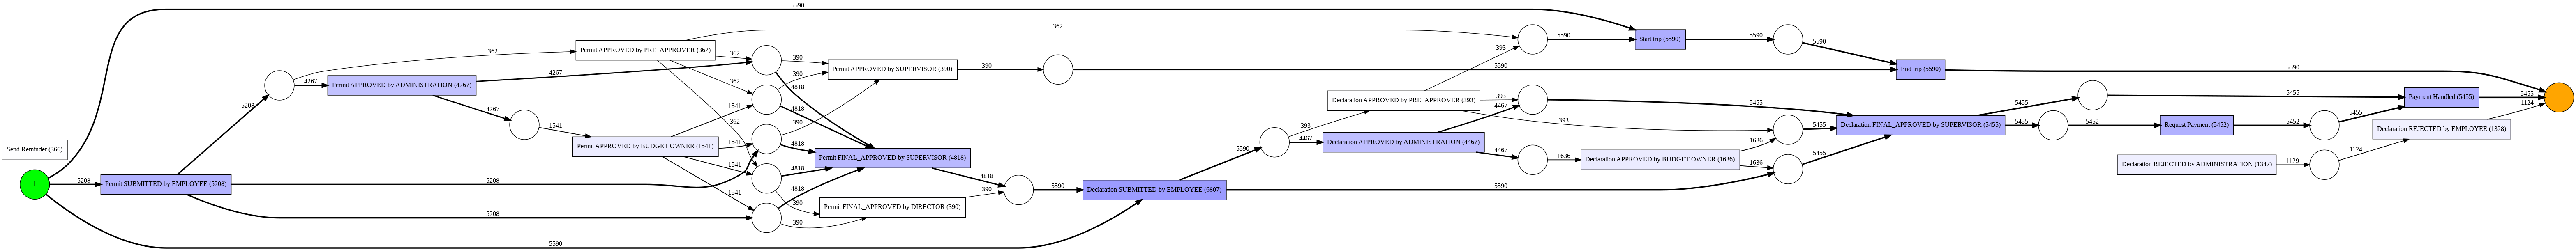

In [42]:
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petrinet import visualizer as pn_visualizer

alpha, alpha_initial_marking, alpha_final_marking = alpha_miner.apply(idl_f)
_ = pn_visualizer.apply(alpha, alpha_initial_marking, alpha_final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=idl_f)
pn_visualizer.view(_)

### Inductive miner Tree


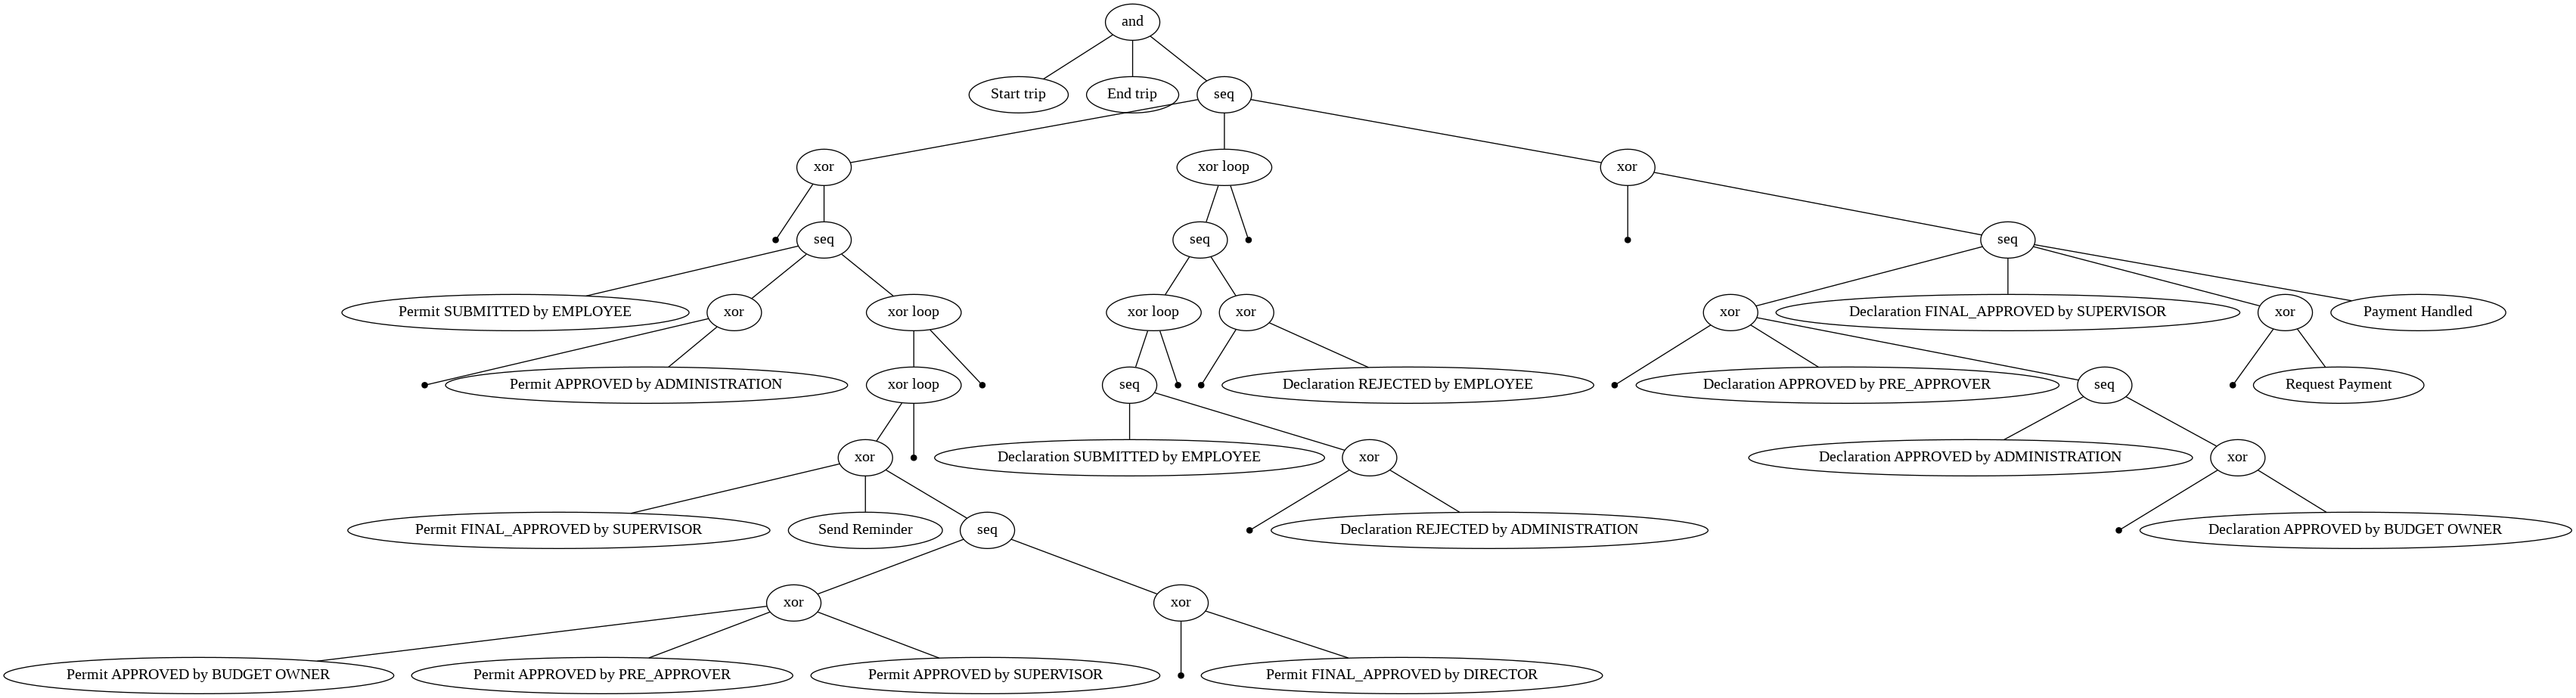

In [43]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer

inductive_tree = inductive_miner.apply_tree(idl_f)
_ = pt_visualizer.apply(inductive_tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(_)

### Inductive Miner Petri net

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  


replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

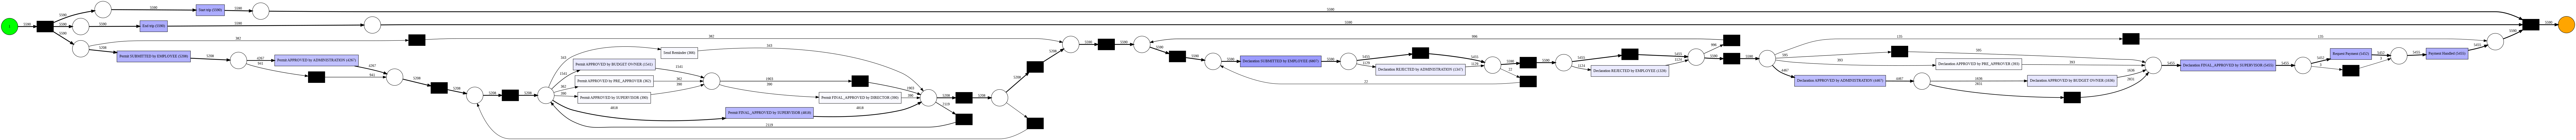

In [44]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
inductive, inductive_initial_marking, inductive_final_marking = pt_converter.apply(inductive_tree)
## Then visualise
_ = pn_visualizer.apply(inductive, inductive_initial_marking, inductive_final_marking,
                          variant=pn_visualizer.Variants.FREQUENCY,
                          log=idl_f)
pn_visualizer.view(_)

## Heuristic miner

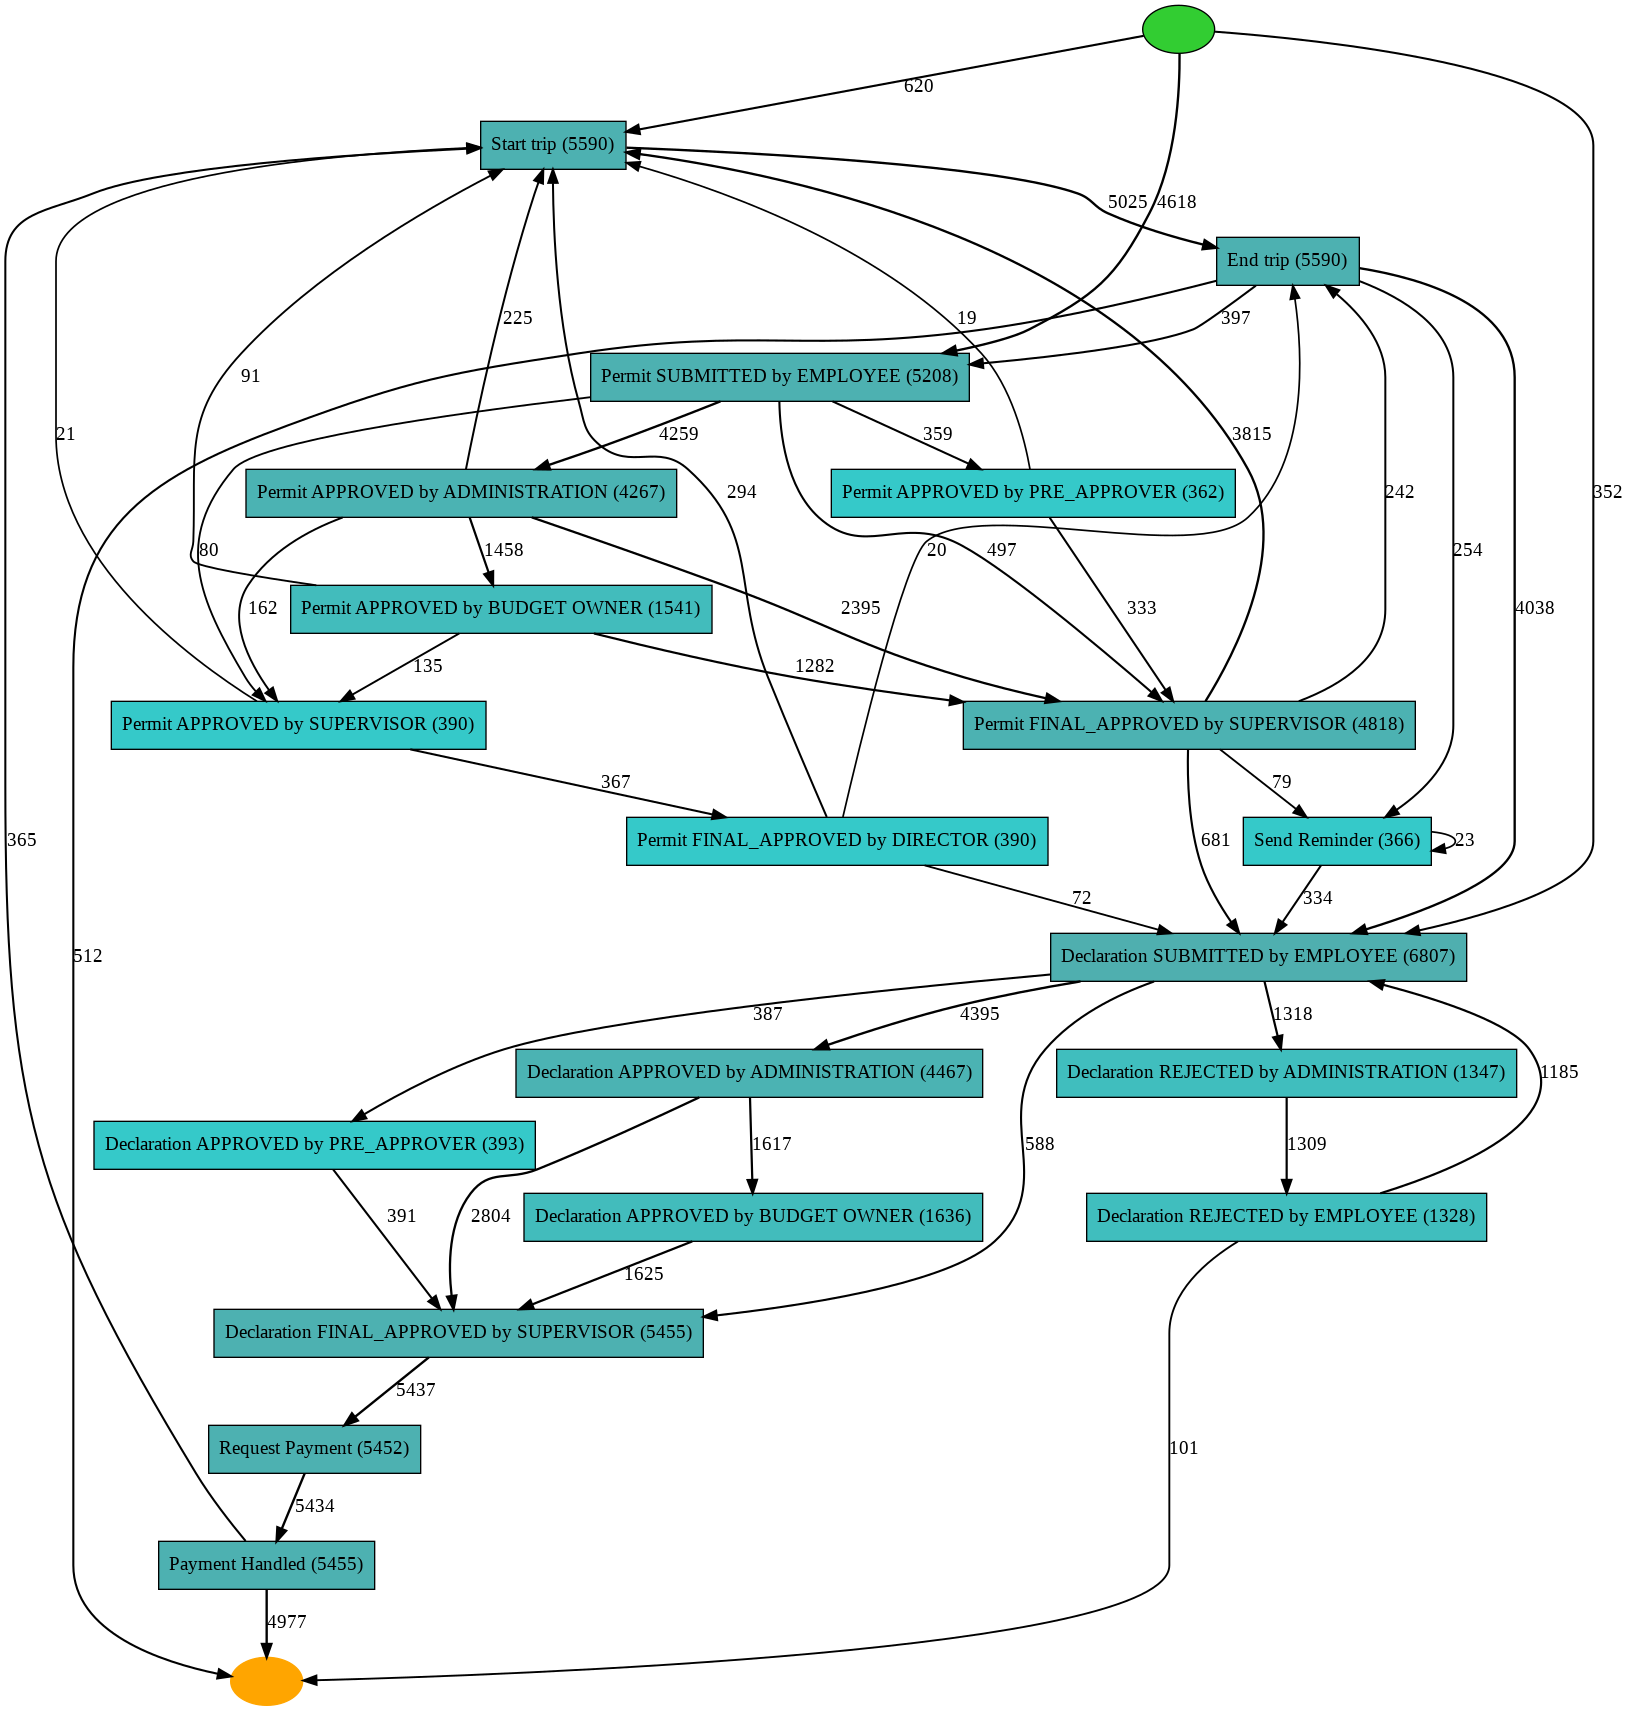

In [45]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

heuristic = heuristics_miner.apply_heu(idl_f, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.95})
_ = hn_visualizer.apply(heuristic)
hn_visualizer.view(_)

### Heuristic miner petrinet

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  


replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

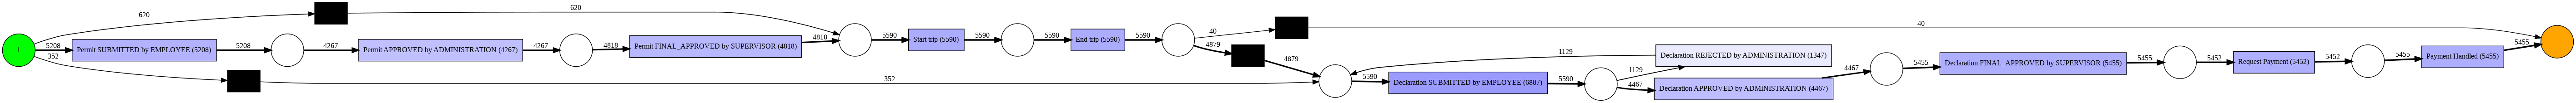

In [46]:
heuristic, heuristic_initial_marking, heuristic_final_marking = heuristics_miner.apply(idl_f, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.9995})
_ = pn_visualizer.apply(heuristic, heuristic_initial_marking, heuristic_final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=idl_f)
pn_visualizer.view(_)

### DFG


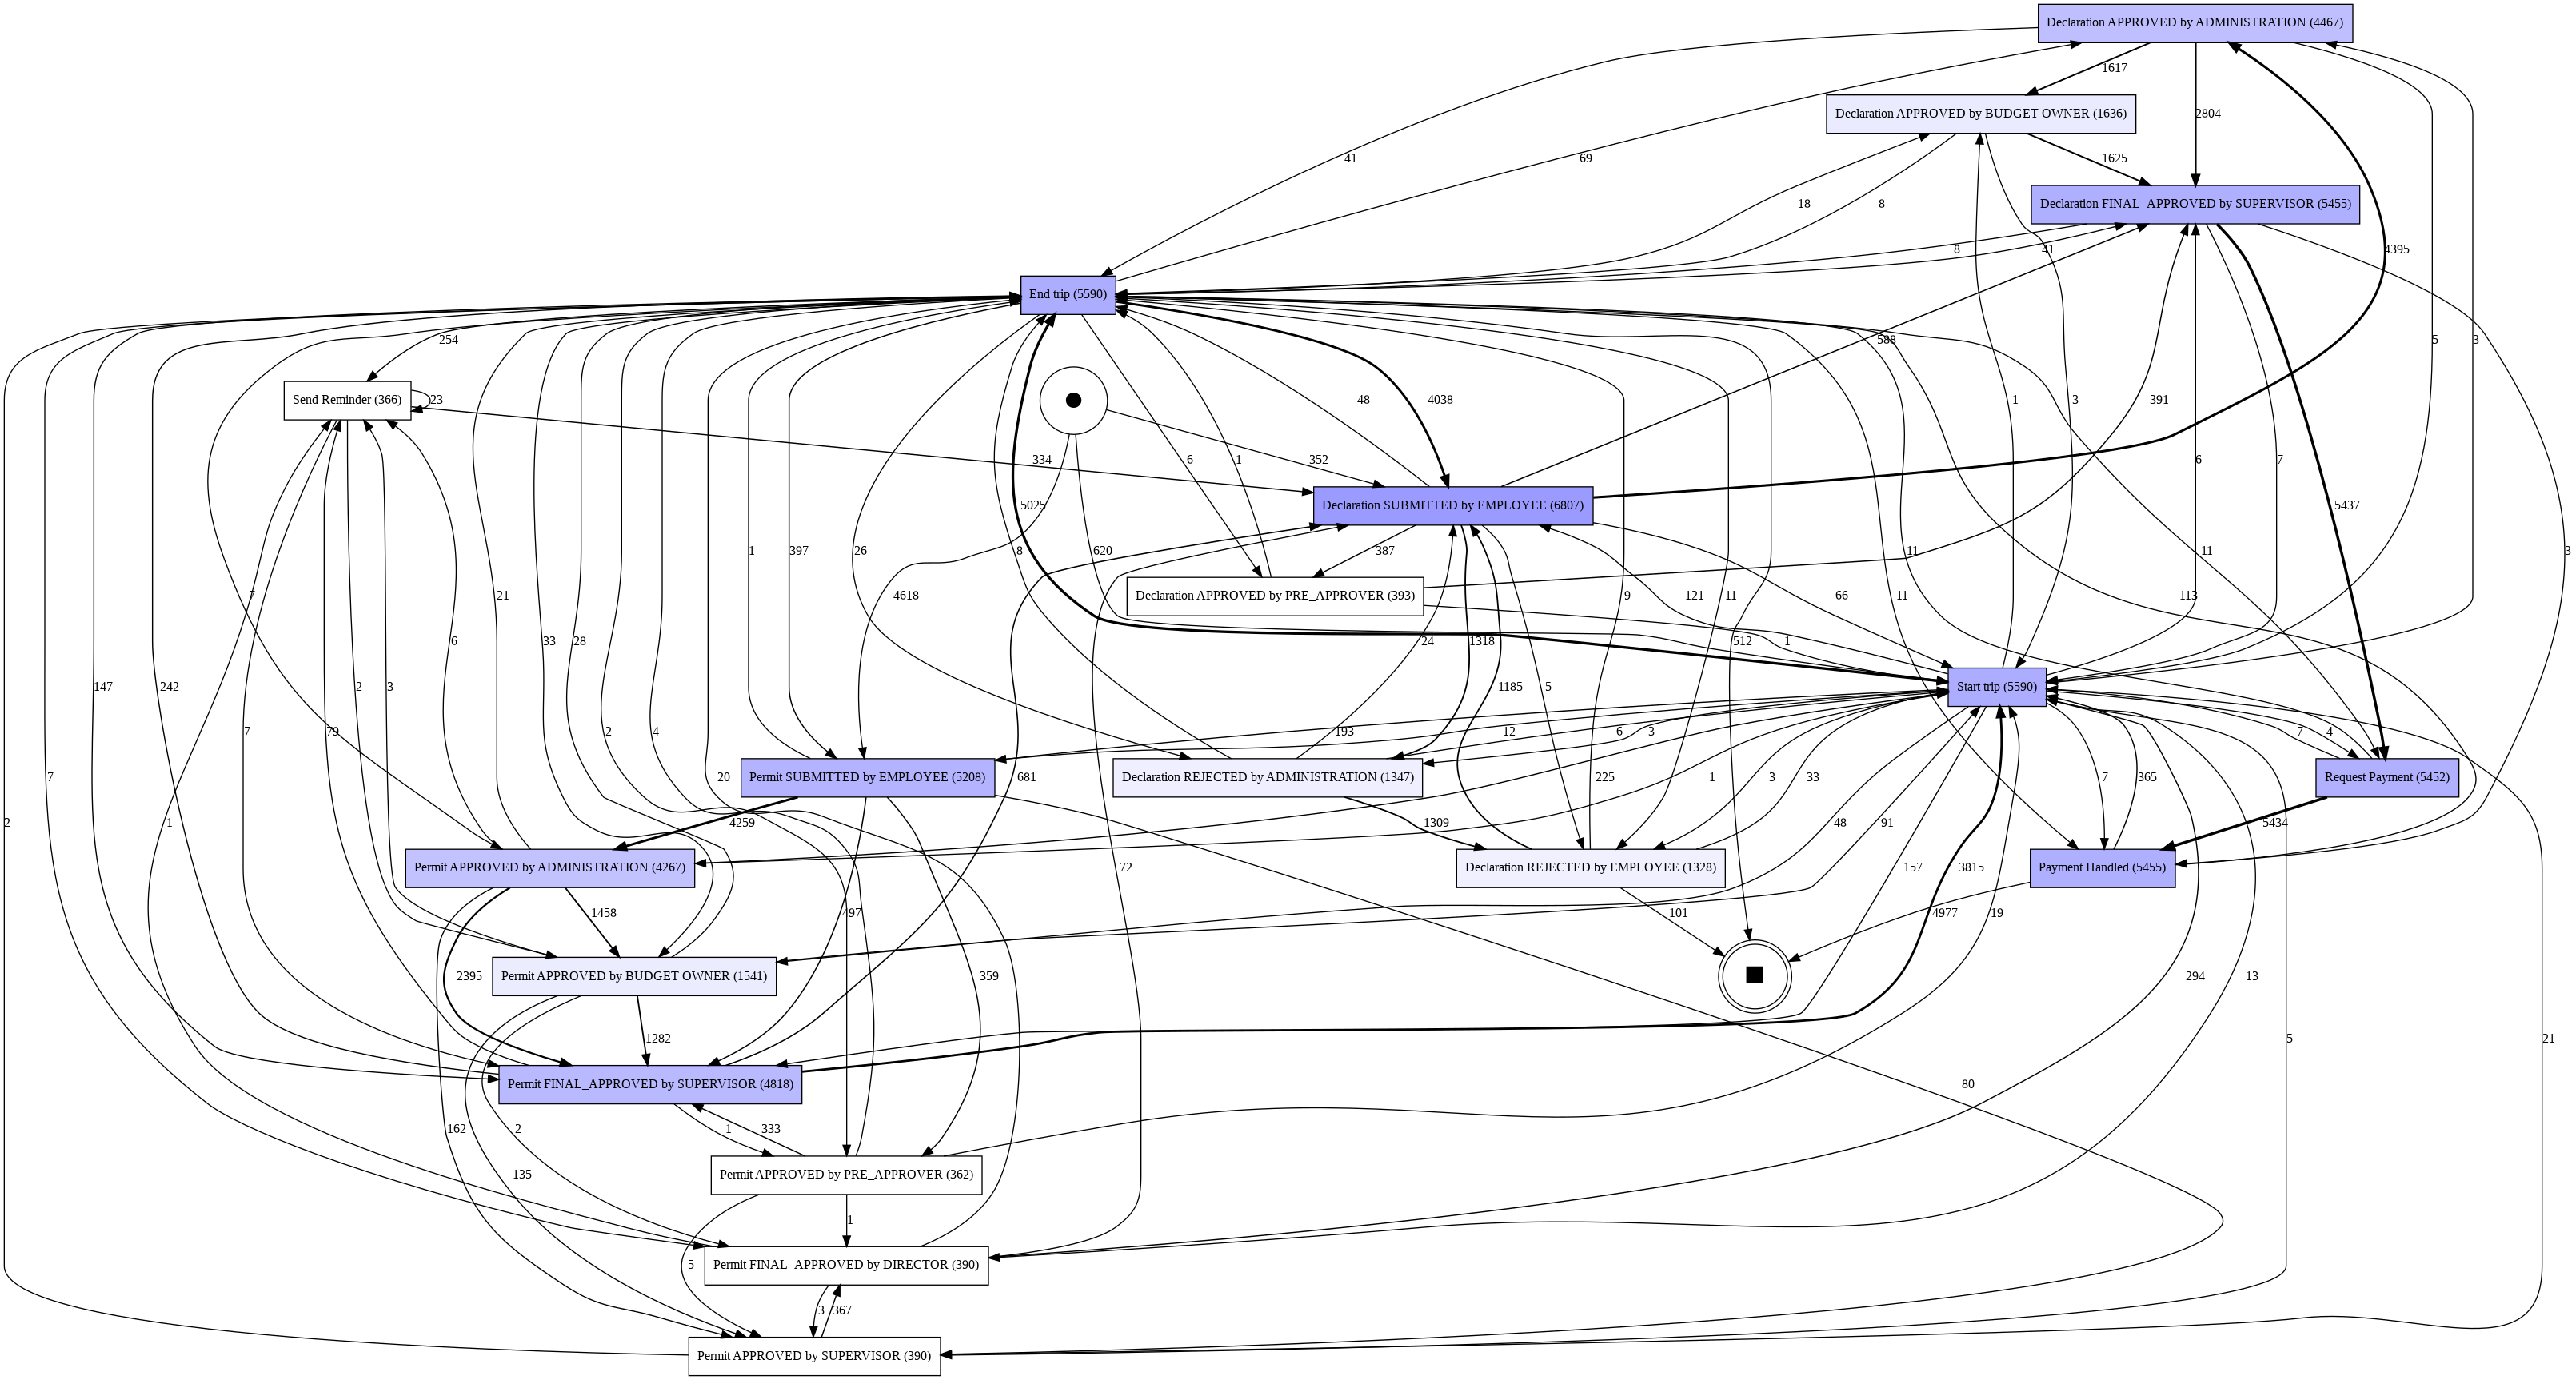

In [47]:
dfg, start_activities, end_activities = pm4py.discover_dfg(idl_f)
pm4py.view_dfg(dfg, start_activities, end_activities)

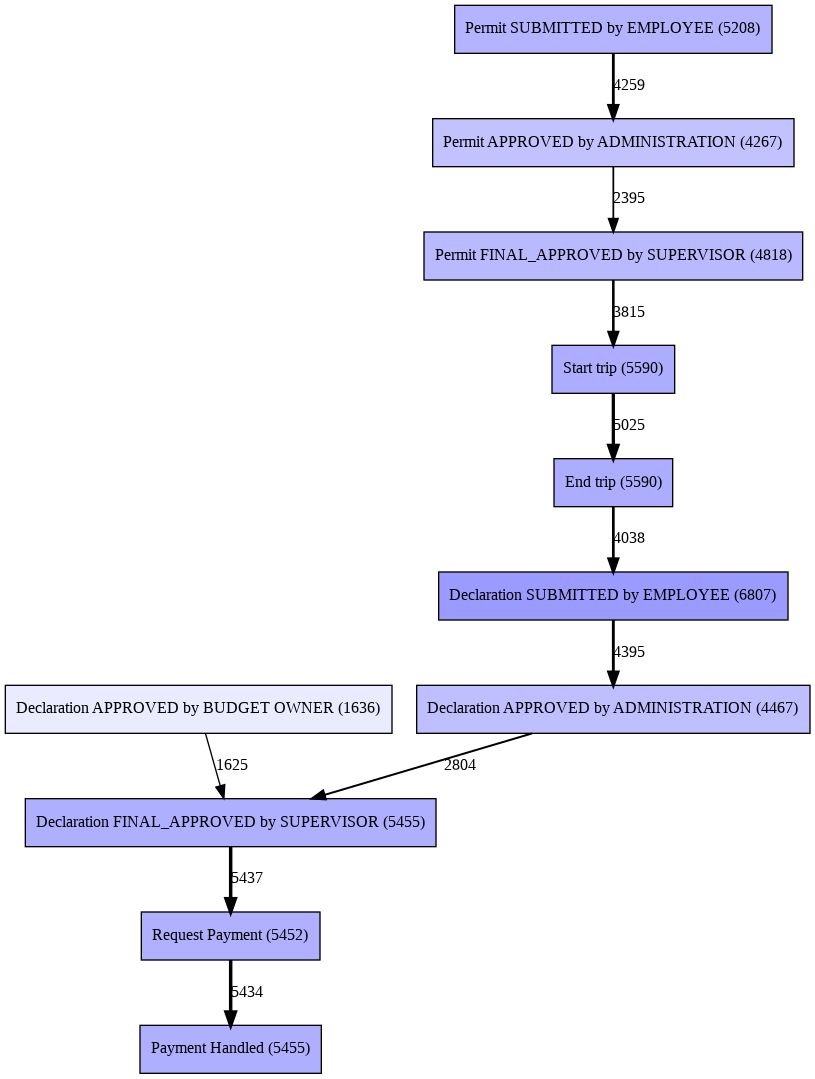

In [48]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg  = dfg_discovery.apply(idl_f)
_ = dfg_visualization.apply(dfg, log=idl_f, variant=dfg_visualization.Variants.FREQUENCY, parameters={dfg_visualization.Variants.FREQUENCY.value.Parameters.MAX_NO_EDGES_IN_DIAGRAM:10})
dfg_visualization.view(_)

## Conformance Checking

### Alpha

In [49]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

fitness_alpha = replay_fitness_evaluator.apply(idl_f, alpha, alpha_initial_marking, alpha_final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
prec_alpha = precision_evaluator.apply(idl_f, alpha, alpha_initial_marking, alpha_final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
gen_alpha = generalization_evaluator.apply(idl_f, alpha, alpha_initial_marking, alpha_final_marking)
simp_alpha = simplicity_evaluator.apply(alpha)

print("Fitness: ",fitness_alpha["average_trace_fitness"])
print("Precision: ",prec_alpha)
print("Generalization: ",gen_alpha)
print("Simplicity: ",simp_alpha)

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

Fitness:  0.7501875301560648
Precision:  0.406324859974149
Generalization:  0.9737126556118553
Simplicity:  0.4823529411764706


### Inductive

In [50]:
fitness_inductive = replay_fitness_evaluator.apply(idl_f, inductive, inductive_initial_marking, inductive_final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
prec_inductive = precision_evaluator.apply(idl_f, inductive, inductive_initial_marking, inductive_final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
gen_inductive = generalization_evaluator.apply(idl_f, inductive, inductive_initial_marking, inductive_final_marking)
simp_inductive = simplicity_evaluator.apply(inductive)

print("Fitness: ",fitness_inductive["average_trace_fitness"])
print("Precision: ",prec_inductive)
print("Generalization: ",gen_inductive)
print("Simplicity: ",simp_inductive)

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

Fitness:  1.0
Precision:  0.4761532835361515
Generalization:  0.9346736337922591
Simplicity:  0.6448598130841122


### Heuristic

In [60]:
fitness_heuristic = replay_fitness_evaluator.apply(idl_f, heuristic, heuristic_initial_marking, heuristic_final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
prec_heuristic = precision_evaluator.apply(idl_f, heuristic, heuristic_initial_marking, heuristic_final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
gen_heuristic = generalization_evaluator.apply(idl_f, heuristic, heuristic_initial_marking, heuristic_final_marking)
simp_heuristic = simplicity_evaluator.apply(heuristic)

print("Fitness: ",fitness_heuristic["average_trace_fitness"])
print("Precision: ",prec_heuristic)
print("Generalization: ",gen_heuristic)
print("Simplicity: ",simp_heuristic)

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

Fitness:  0.9324563975938984
Precision:  0.9796508660291966
Generalization:  0.9712556334092205
Simplicity:  0.8181818181818181
